In [1]:
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import pandas as pd

2022-12-01 15:10:32.504455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
symptom_data = pd.read_csv("./datasets/combined.csv")
media_data = pd.read_csv("./datasets/media_count_ratio_all_2021.csv")

In [3]:
symptom = "symptom:combined"


a = symptom_data[symptom]
b = media_data[symptom]
c = symptom_data["daily_new_positives"]


features = ["symptom", "media"]
target = "case"


df = pd.concat([a, b, c], axis=1)
df.columns = features + [target]
df

,symptom,media,case
0,14.8431,0.019437,15074
1,14.8717,0.019680,11368
2,14.7662,0.015565,11209
3,15.3282,0.013347,12666
4,15.6898,0.013250,16648
...,...,...,...
360,27.0476,0.024868,40780
361,28.7918,0.000000,67090
362,28.3798,0.056667,74207
363,27.3794,0.033786,76555


In [4]:
test_start = int(365 * 0.8)

df_train = df.loc[:test_start].copy()
df_test = df.loc[test_start:].copy()

In [5]:
X_train = df_train[["symptom", "media"]]
X_test = df_test[["symptom", "media"]]

y_train = df_train[["case"]]
y_test = df_test[["case"]]

In [6]:
import numpy as np
from numpy import hstack

In [7]:
input_feat1 = np.array(X_train["symptom"])
input_feat2 = np.array(X_train["media"])
out_seq_train = np.array(y_train["case"])

In [8]:
input_feat1 = input_feat1.reshape((len(input_feat1), 1))
input_feat2 = input_feat2.reshape((len(input_feat2), 1))
out_seq_train = out_seq_train.reshape((len(out_seq_train), 1))

In [9]:
train_mod = hstack((input_feat1, input_feat2, out_seq_train))

In [10]:
input_feat1 = np.array(X_test["symptom"])
input_feat2 = np.array(X_test["media"])
out_seq_test = np.array(y_test["case"])

In [11]:
input_feat1 = input_feat1.reshape((len(input_feat1), 1))
input_feat2 = input_feat2.reshape((len(input_feat2), 1))
out_seq_test = out_seq_test.reshape((len(out_seq_test), 1))

In [12]:
test_mod = hstack((input_feat1, input_feat2, out_seq_test))

In [13]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_features = train_mod.shape[1]
n_input = 7

store_2 = len(train_mod)

time_for_train = TimeseriesGenerator(
    train_mod, out_seq_train, length=n_input, batch_size=store_2
)

In [14]:
time_for_test = TimeseriesGenerator(
    test_mod, out_seq_test, length=n_input, batch_size=1
)

In [15]:
print("steps, feats:", n_input, n_features)

steps, feats: 7 3


In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN, SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers.core import Activation
from keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler

In [17]:
model = Sequential()

model.add(
    SimpleRNN(
        6, activation="relu", input_shape=(n_input, n_features), return_sequences=False
    )
)
model.add(Dense(1, activation="relu"))

adam = Adam(lr=0.01)
model.compile(optimizer=adam, loss="mse")

2022-12-01 15:10:39.296663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mohit/opt/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 6)                 60        
                                                                 
 dense (Dense)               (None, 1)                 7         
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


In [19]:
score = model.fit_generator(
    time_for_train,
    epochs=150,
    verbose=1,
    validation_data=time_for_test,
    shuffle=False,
)

Epoch 1/150


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/2090982379.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  score = model.fit_generator(


1/1 [==============================] - 1s 979ms/step - loss: 11843231.0000 - val_loss: 270827520.0000
Epoch 2/150
1/1 [==============================] - 0s 98ms/step - loss: 9687985.0000 - val_loss: 239882000.0000
Epoch 3/150
1/1 [==============================] - 0s 99ms/step - loss: 7621299.0000 - val_loss: 209190304.0000
Epoch 4/150
1/1 [==============================] - 0s 100ms/step - loss: 5611441.0000 - val_loss: 178572688.0000
Epoch 5/150
1/1 [==============================] - 0s 97ms/step - loss: 3790253.7500 - val_loss: 148142800.0000
Epoch 6/150
1/1 [==============================] - 0s 100ms/step - loss: 2349406.7500 - val_loss: 118689680.0000
Epoch 7/150
1/1 [==============================] - 0s 104ms/step - loss: 1468031.8750 - val_loss: 92360008.0000
Epoch 8/150
1/1 [==============================] - 0s 100ms/step - loss: 1286166.8750 - val_loss: 71795624.0000
Epoch 9/150
1/1 [==============================] - 0s 96ms/step - loss: 1749079.6250 - val_loss: 59652756.0000
E

In [20]:
import matplotlib.pyplot as plt

In [21]:
df_result = pd.DataFrame({"Actual": [], "Prediction": []})

store_1 = len(time_for_test)

for i in range(store_1):
    
    x, y = time_for_test[i]
    
    x_input = np.array(x).reshape((1, n_input, n_features))
    
    store_yhat = model.predict(x_input, verbose=2)
    
    df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)

1/1 - 0s - 123ms/epoch - 123ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: 

1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 14ms/epoch - 14ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: 

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: 

1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: 

1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: 

1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 14ms/epoch - 14ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: 

1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: 

1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: 

1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: 

1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: 

1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: 

1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)


1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)
/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: 

1/1 - 0s - 15ms/epoch - 15ms/step


/var/folders/18/4s2_njc94pv_nkk_33fxl4700000gn/T/ipykernel_1975/1088707662.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({"Actual": y, "Prediction": store_yhat}, ignore_index=True)


In [22]:

diff_sub = (df_result["Prediction"] - df_result["Actual"])

df_result["Diff"] = (
    100 * diff_sub / df_result["Actual"]
)

store_4 = df_result.columns

for i in list(store_4):
    df_result[i] = df_result[i].apply(lambda x: x[0][0])

df_result.to_csv("rnn_eeout.csv")

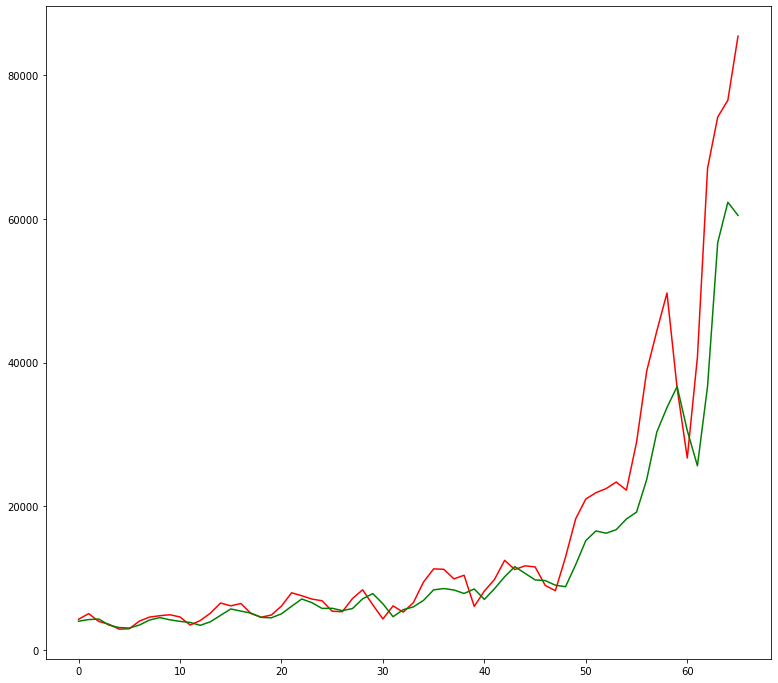

In [23]:
plt.figure(figsize=(13, 12))
plt.plot(df_result["Actual"], color="red")
plt.plot(df_result["Prediction"], color="green")

In [24]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - (y_true))))

In [25]:
print(root_mean_squared_error(df_result["Actual"], df_result["Prediction"]))

7144.224045136396


In [26]:
from modules.utils import SYMPTOM_COLUMNS, SYMPTOM_NAMES
from modules.eval import *
from modules.plot import *

run_eval_suite_default(df_result["Prediction"], df_result["Actual"])

{'rmse': 7144.224045136396,
 'dtw distance': 1.0448027116051644,
 'pearson statistic': 0.9773756953791393,
 'pearson p-value': 6.730484258266209e-45,
 'spearman rho': 0.9602546707024321,
 'spearman p-value': 3.5104926651783416e-37}

In [27]:
_ = get_model_results(
    df_result["Prediction"],
    df_result["Actual"],
    "rnn_seqlen_7_with_media",
    media=False,
    lead=0,
    save=True,
)

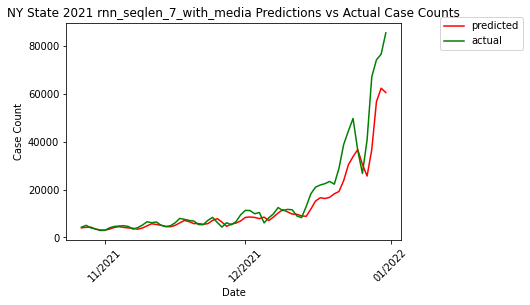

In [28]:
plot_predictions_actual(_, "rnn_seqlen_7_with_media")